### Evaluate SHM-seq vs mechanical extraction of bacterial RNA

Input files:<br>
Bacpipeline output file SHM-Seq: QCenz_$*$Bacstdata.tsv<br>
Bacpipeline output file mechanical extraction: QCmech_$*$Bacstdata.tsv

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from scipy.stats import linregress, spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_names = {'QCenz_C1':'enzymatic',
             'QCenz_D1':'enzymatic',
             'QCenz_E1':'enzymatic',
             'QCmech_C1':'mechanic',
             'QCmech_D1':'mechanic',
             'QCmech_E1':'mechanic'}

# tsv files

In [7]:
# Read tsv files

path = ''

taxa_order = ['genus', 'family', 'order', 'class', 'phylum']

tsv_d = {}

for file in os.listdir(path):
    if file.endswith("Bacstdata.tsv"):
        name = file.split('/')[-1].split('_Bac')[0]
        #print(name)
        df = pd.read_csv(os.path.join(path, file), sep='\t')
        df.drop(columns='Unnamed: 0', inplace=True)
        
        df[['genus','family', 'order', 'class', 'phylum', 'domain']] = df['taxa_order'].str.split(',',expand=True)
        df['name'] = name
        df['type'] = df['name'].map(file_names)
        
        sum_fq = df['fastq'].sum()
        # Calculate relative abundances on genus level
        df['rel.abund'] = df['fastq'] / sum_fq *100
        
        df = df.loc[:,['genus', 'type', 'rel.abund']]
        df = pd.pivot(data=df, index='genus', columns='type', values='rel.abund')
        df.reset_index(inplace=True)
        df.sort_values(by='genus')
        tsv_d[name] = df

fe = pd.concat([tsv_d['QCenz_C1'], tsv_d['QCenz_D1'], tsv_d['QCenz_E1']])
fm = pd.concat([tsv_d['QCmech_C1'], tsv_d['QCmech_D1'], tsv_d['QCmech_E1']])

fe = pd.melt(fe, id_vars=['genus'], value_vars='enzymatic')
fe = fe.groupby('genus').mean()
fe.columns = ['enzymatic']
fm = pd.melt(fm, id_vars=['genus'], value_vars='mechanic')
fm = fm.groupby('genus').mean()
fm.columns = ['mechanic']
        
f = pd.concat([fe, fm], axis = 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson's r: 0.948 pvalue: 5.509069594222175e-21


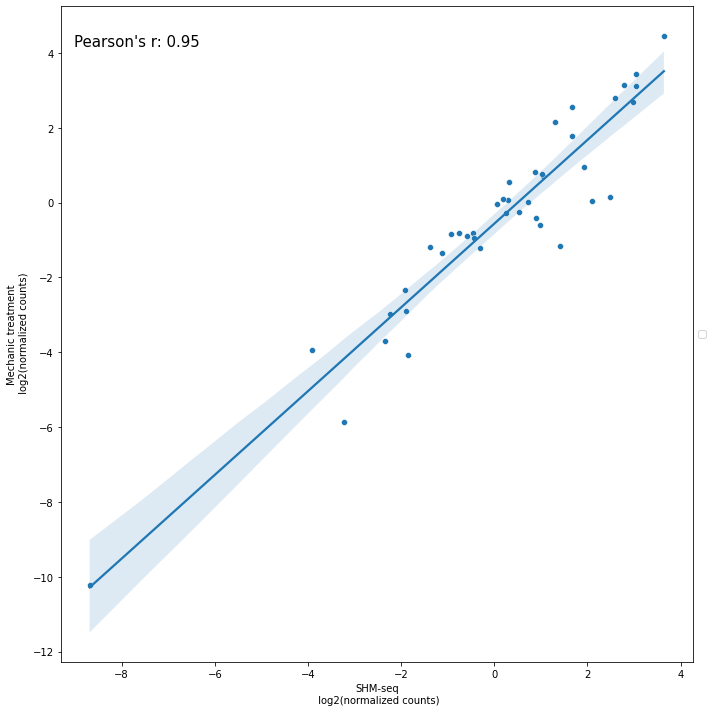

In [8]:
#Plot

# initialize a figure
fig = plt.figure(figsize=(10, 10))

# for a 1x1 subplot
axes = []
for row_idx in range(0,1):
    for col_idx in range(0,1):
        ax = plt.subplot2grid((1, 1), (row_idx, col_idx))

x = 'enzymatic'
y = 'mechanic'

f = np.log2(f)
f.reset_index(inplace=True)
        
sns.regplot(x=x, y=y, data=f, ax=ax, x_ci='ci', scatter_kws={'rasterized':True, 's':1})
sns.scatterplot(x=x, y=y, data=f, ax=ax) # 

ax.set_xlabel('SHM-seq\n log2(normalized counts)')
ax.set_ylabel('Mechanic treatment\n log2(normalized counts)')

# Pearson's r
pear, pp = pearsonr(f[x], f[y])
print("Pearson's r: " + str(round(pear, 3)) + ' pvalue: ' + str(pp))

ax.text(0.02, 0.94, "Pearson's r: " + str(round(pear, 2)), transform=ax.transAxes, fontsize=15)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
